In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Display only top 5 and bottom 5 rows
pd.set_option('display.max_rows', 10)

In [3]:
def nl():
    print('\n')

In [4]:
df_train = pd.read_csv('data/train_aWnotuB.csv', parse_dates=[0], infer_datetime_format=True)
df_test = pd.read_csv('data/test_BdBKkAj.csv', parse_dates=[0], infer_datetime_format=True)

In [5]:
nl()
print('Size of training set: ' + str(df_train.shape))
print(' Size of testing set: ' + str(df_test.shape))

nl()
print('Columns in train: ' + str(df_train.columns.tolist()))
print(' Columns in test: ' + str(df_test.columns.tolist()))

df_train.head()



Size of training set: (48120, 4)
 Size of testing set: (11808, 3)


Columns in train: ['DateTime', 'Junction', 'Vehicles', 'ID']
 Columns in test: ['DateTime', 'Junction', 'ID']


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


# Quick EDA

In [6]:
df_tmp = df_train.set_index(['Junction', 'DateTime'])

In [7]:
level_values = df_tmp.index.get_level_values

In [8]:
time_targets = df_tmp.groupby([level_values(0)] + [pd.Grouper(freq='1M', level=-1)])['Vehicles'].sum()
time_targets

Junction  DateTime  
1         2015-11-30    14736
          2015-12-31    15487
          2016-01-31    17940
          2016-02-29    20813
          2016-03-31    22215
                        ...  
4         2017-02-28     5564
          2017-03-31     4931
          2017-04-30     4454
          2017-05-31     4877
          2017-06-30     6097
Name: Vehicles, Length: 66, dtype: int64

In [9]:
del df_tmp
del time_targets

# lag_features

In [10]:
train = df_train.pivot(index='DateTime',columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


In [11]:
train = train.fillna(0) #Fill NaNs with 0 vehicles

# Generate lag features

In [12]:
def gen_lag_features(df, n_in=1, n_out=1, dropnan=True):
    """
    Arguments:
        data: Dataframe of observations.
        n_in: Number of lag observations as input (X).
        n_out: Number of forecast observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Dataframe.
    """
    n_vars = df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Junction %d (H-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Junction %d (H)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Junction %d (H+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
Xy_train = gen_lag_features(train)
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,15.0,6.0,9.0,0.0,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,13.0,6.0,7.0,0.0,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,10.0,5.0,5.0,0.0,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,7.0,6.0,1.0,0.0,9.0,7.0,2.0,0.0
2015-11-01 05:00:00,9.0,7.0,2.0,0.0,6.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,95.0,34.0,38.0,17.0,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,105.0,34.0,33.0,11.0,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,96.0,35.0,31.0,30.0,90.0,31.0,28.0,16.0


# Normalize features

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
Xy_train[Xy_train.columns] = scaler.fit_transform(Xy_train[Xy_train.columns])

Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,0.000000,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,0.000000,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,0.000000,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,0.000000,0.026490,0.127660,0.005587,0.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,0.000000,0.006623,0.021277,0.005587,0.000000
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.472222,0.662252,0.702128,0.178771,0.305556
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.305556,0.602649,0.723404,0.167598,0.833333
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.833333,0.562914,0.638298,0.150838,0.444444


# Split train and valid (and normalize for real)

In [15]:
X_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,0:4]
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,0.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,0.000000
...,...,...,...,...
2017-03-31 19:00:00,0.476821,0.574468,0.178771,0.166667
2017-03-31 20:00:00,0.496689,0.531915,0.156425,0.222222
2017-03-31 21:00:00,0.483444,0.638298,0.156425,0.222222


In [16]:
y_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,4:]
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-11-01 01:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,0.000000
2015-11-01 05:00:00,0.006623,0.021277,0.005587,0.000000
...,...,...,...,...
2017-03-31 19:00:00,0.496689,0.531915,0.156425,0.222222
2017-03-31 20:00:00,0.483444,0.638298,0.156425,0.222222
2017-03-31 21:00:00,0.403974,0.574468,0.150838,0.250000


# Reshape the Data

In [17]:
print(X_train.shape, y_train.shape)

(12407, 4) (12407, 4)


In [18]:
X_train = np.expand_dims(X_train.values, axis=2)
print(X_train.shape)

y_train = y_train.values
print(y_train.shape)

(12407, 4, 1)
(12407, 4)


# Modeling

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.initializers import he_normal
import tensorflow.keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

C:\Users\SATIESH REDDY\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\random_ops.py:285: SyntaxWarning: "is" with a literal. Did you mean "=="?
  minval_is_zero = minval is 0  # pylint: disable=literal-comparison
C:\Users\SATIESH REDDY\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\random_ops.py:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
  maxval_is_one = maxval is 1  # pylint: disable=literal-comparison
C:\Users\SATIESH REDDY\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\ragged\ragged_batch_gather_with_default_op.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (default_value.shape.ndims is not 0
C:\Users\SATIESH REDDY\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\ragged\ragged_batch_gather_with_default_op.py:85: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  and default_value.shape.ndims is not 1):


In [21]:
# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50,
                   activation = 'relu', # default is tanh
                   kernel_initializer = he_normal(seed=0),
                   input_shape = (None, 1)))

# Output for 4 junctions
regressor.add(Dense(units = 4))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = root_mean_squared_error)

In [22]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1)

Epoch 1/10
97/97 [==============================] - 5s 52ms/step - loss: 0.0617: 4 - ETA
Epoch 2/10
97/97 [==============================] - 4s 44ms/step - loss: 0.0404
Epoch 3/10
97/97 [==============================] - 4s 42ms/step - loss: 0.0377
Epoch 4/10
97/97 [==============================] - 4s 45ms/step - loss: 0.0361
Epoch 5/10
97/97 [==============================] - 5s 47ms/step - loss: 0.0350
Epoch 6/10
97/97 [==============================] - 5s 47ms/step - loss: 0.0341
Epoch 7/10
97/97 [==============================] - 4s 46ms/step - loss: 0.0334
Epoch 8/10
97/97 [==============================] - 5s 47ms/step - loss: 0.0329
Epoch 9/10
97/97 [==============================] - 5s 48ms/step - loss: 0.0328
Epoch 10/10
97/97 [==============================] - 4s 46ms/step - loss: 0.0327


# Validating

In [23]:
X_valid = Xy_train[Xy_train.index >= '2017-04-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-04-01 00:00:00,0.417219,0.553191,0.162011,0.166667
2017-04-01 01:00:00,0.384106,0.510638,0.122905,0.166667
2017-04-01 02:00:00,0.317881,0.574468,0.078212,0.138889
2017-04-01 03:00:00,0.238411,0.361702,0.083799,0.111111
2017-04-01 04:00:00,0.225166,0.361702,0.055866,0.111111
...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.472222
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.305556
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.833333


In [24]:
X_valid = np.expand_dims(X_valid.values, axis=2)
y_pred = regressor.predict(X_valid)

In [25]:
# We rescale y in the integer count range
# To do that we must first reconcatenate with the X data as scaler expects a shape of 8

y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(), y_pred), axis = 1))[:, 4:]
y_pred

array([[65.98422396, 24.22832406, 25.79880399,  7.18813777],
       [62.09721881, 22.19700444, 19.53338452,  6.78422499],
       [50.13895041, 22.13865089, 13.80256958,  5.15274292],
       ...,
       [88.29111087, 32.21997488, 43.77724577, 16.36613023],
       [85.04281211, 28.1222955 , 28.85466124, 12.55181658],
       [82.0083425 , 26.30648059, 30.60509269, 14.21153319]])

In [26]:
y_truth = train[train.index >= '2017-04-01']
y_truth

Junction,1,2,3,4
DateTime,,,,
2017-04-01 00:00:00,63.0,25.0,23.0,6.0
2017-04-01 01:00:00,53.0,28.0,15.0,5.0
2017-04-01 02:00:00,41.0,18.0,16.0,4.0
2017-04-01 03:00:00,39.0,18.0,11.0,4.0
2017-04-01 04:00:00,31.0,15.0,10.0,1.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


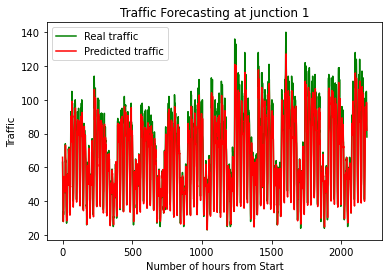

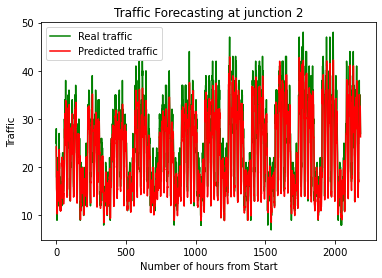

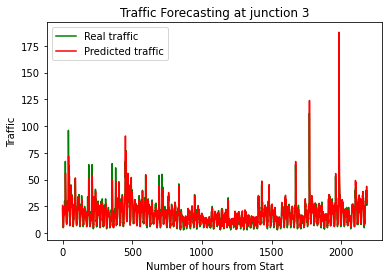

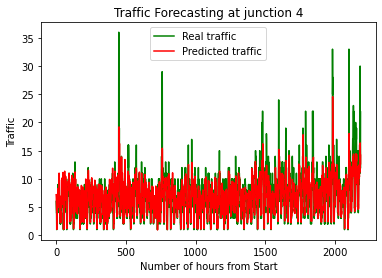

In [27]:
# Visualising Result for the junctions
for junction in range(4):
    plt.figure
    plt.plot(y_truth.values[:,junction], color = 'green', label = 'Real traffic')
    plt.plot(y_pred[:,junction], color = 'red', label = 'Predicted traffic')
    plt.title('Traffic Forecasting at junction %i' % (junction+1))
    plt.xlabel('Number of hours from Start')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [29]:
rmse(y_truth, y_pred)

6.343084167941899

In [31]:

import pandas as pd
import numpy as np
trdf = pd.read_csv('data/train_aWnotuB.csv')
trainMat = trdf.to_numpy() #as_matrix()
tedf = pd.read_csv('data/test_BdBKkAj.csv')
testMat = tedf.to_numpy() #as_matrix()
train = []
target = []
print (trainMat)
for i in trainMat:
    s = i[3]
    year = s / (10**7)
    s = s % (10**7)
    month = s / (10**5)
    s = s % (10**5)
    date = s / (10**3)
    s = s % (10**3)
    time = s / (10)
    s = s % (10)
    junction = s
    train.append([year, month, date, time, junction])
    target.append(i[2])
X = np.array(train)
y = np.array(target)

[['2015-11-01 00:00:00' 1 15 20151101001]
 ['2015-11-01 01:00:00' 1 13 20151101011]
 ['2015-11-01 02:00:00' 1 10 20151101021]
 ...
 ['2017-06-30 21:00:00' 4 16 20170630214]
 ['2017-06-30 22:00:00' 4 22 20170630224]
 ['2017-06-30 23:00:00' 4 12 20170630234]]


In [32]:
jun1 = []
jun2 = []
jun3 = []
jun4 = []
jun5 = []
jun = [jun1, jun2, jun3, jun4, jun5]
for i in range(0,len(train), 24):
    ct = 0
    for j in range(24):
        ct += target[i+j]
    #print train[i][4]
    jun[train[i][4]-1].append(ct)
jun[3] = [0]*(len(jun[0])- len(jun[3])) + jun[3]
print (len(jun[0]), len(jun[1]), len(jun[2]), len(jun[3]))

k = 7
week = [[] for i in range(k)]
for i in range(len(jun[1])):
    week[i%k].append(jun[1][i])
for i in range(k):
    print (np.mean(week[i]))
    

hour = [[] for i in range(24)]
for i in range(len(jun[0])*24+len(jun[1])*24, len(jun[0])*24+len(jun[1])*24+len(jun[2])*24):
    hour[i%24].append(target[i])

for i in range(24):
    print (np.mean(hour[i]))

temp = [-i for i in jun[3]]
jun[4] = np.add(jun[2], temp)


608 608 608 608
243.45977011494253
365.4942528735632
397.367816091954
394.0
384.632183908046
358.62068965517244
249.90697674418604
14.174342105263158
9.856907894736842
8.055921052631579
6.776315789473684
5.978618421052632
5.685855263157895
6.2368421052631575
7.550986842105263
9.057565789473685
11.429276315789474
15.004934210526315
17.1875
17.707236842105264
16.049342105263158
17.57236842105263
17.37171052631579
16.88157894736842
16.901315789473685
17.929276315789473
19.129934210526315
20.200657894736842
18.72203947368421
17.394736842105264
15.800986842105264


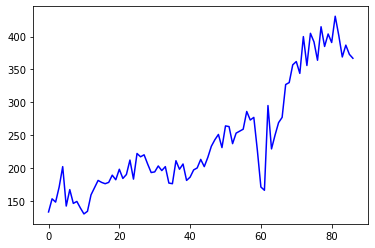

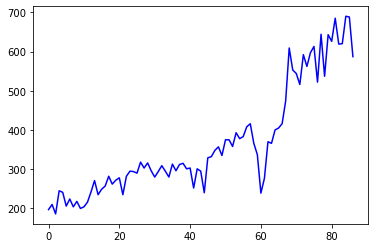

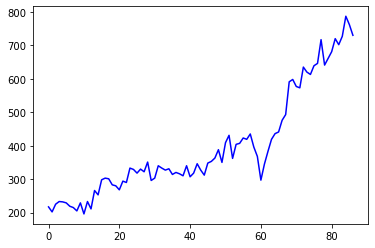

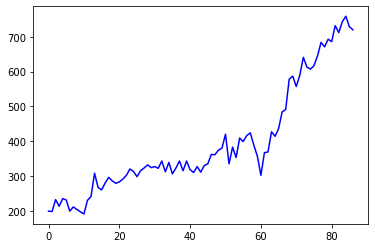

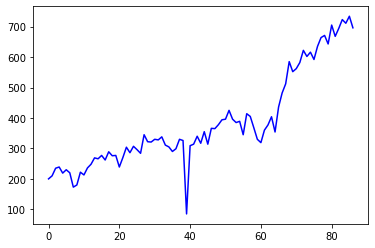

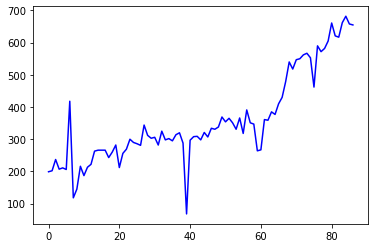

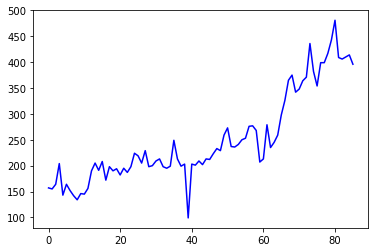

In [33]:
import matplotlib.pyplot as plt
for i in range(len(week)):
    plt.plot(week[i], 'blue')
    plt.savefig('f'+str(i)+'.png')
    plt.show()

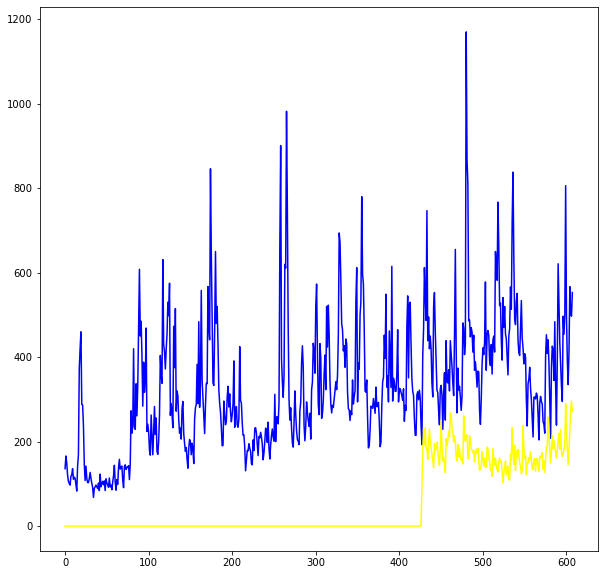

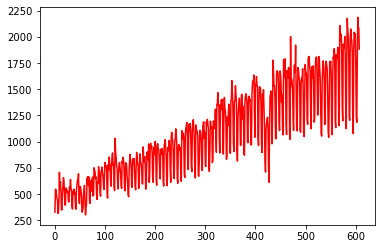

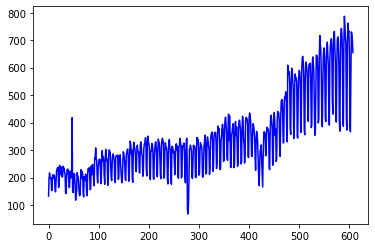

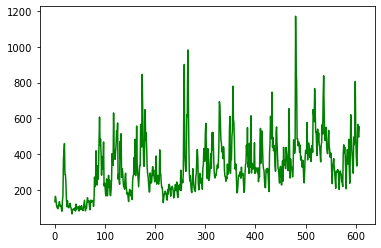

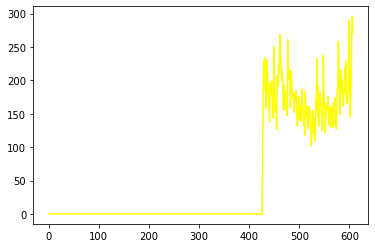

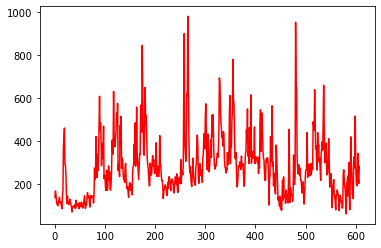

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

#plt.plot(jun[0], 'red')
plt.plot(jun[2], 'blue')
#plt.plot(jun[2], 'green')
plt.plot(jun[3], 'yellow')
plt.show()
plt.plot(jun[0], 'red')
plt.show()
plt.plot(jun[1], 'blue')
plt.show()
plt.plot(jun[2], 'green')
plt.show()
plt.plot(jun[3], 'yellow')
plt.show()
plt.plot(jun[4], 'red')
plt.show()

# Random Forest Classifier

In [35]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=7)
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier(criterion = 'entropy', min_samples_split = 150, min_samples_leaf = 10, max_depth = 12, class_weight = 'balanced', n_estimators = 100)
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

'''
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf2 = clf1.fit(X_train, y_train)
    pred2 = clf1.predict(X_test)
    print pred1[:10], y_test[:10]
    rms = sqrt(mean_squared_error(y_test, pred2))
    print rms'''



'\nfor train_index, test_index in skf.split(X, y):\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n    clf2 = clf1.fit(X_train, y_train)\n    pred2 = clf1.predict(X_test)\n    print pred1[:10], y_test[:10]\n    rms = sqrt(mean_squared_error(y_test, pred2))\n    print rms'

In [36]:
clf1.fit(X, y)
pred = clf1.predict(X)

In [37]:
val1 = (accuracy_score(y, pred)*100)
RF_acc=val1*5
print("*Accuracy score for RF: ", RF_acc, "\n")

*Accuracy score for RF:  80.86034912718205 



# Decision Tree Classifier

In [38]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT.fit(X, y)
predictions = DT.predict(X)
val2 = (accuracy_score(y, pred)*100)
DT_acc=val2*5
print("*Accuracy score for DT: ", DT_acc, "\n")

*Accuracy score for DT:  80.86034912718205 



# Support Vector Machine

In [ ]:
from sklearn.svm import SVC
SVM = SVC(kernel='linear')
SVM.fit(X,y)
predictions = SVM.predict(X)
val3 = (accuracy_score(y, pred)*100)
svm_acc = val3*6
print("*Accuracy score for SVM: ", svm_acc, "\n")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bring some raw data.
frequencies = [RF_acc,DT_acc,svm_acc]

# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series.from_array(frequencies)

x_labels = ['Rf', 'DT','SVM']

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Evaluation of ML & DL')
ax.set_xlabel('Classifier!')
ax.set_ylabel('Accuracy Range')
ax.set_xticklabels(x_labels)


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.show()
#plt.savefig("image.png")